# Test Time Adaptation through Evolutionary Optimised Augmentation

 Giacomo Tomezzoli (241091) &  Davide Vandelli (240207)
 <br/>**Contact:** `{giacomo.tomezzoli, davide.vandelli} [at] studenti.unitn.it`
 <br/>**Github:** `https://github.com/gzemo...`

## Abstract  _Necessario? v. commento prima dell'introduzione_

Abstract section

---

##### Table of contents:
1. [Introduction](#Introduction)
2. [Overview of the project architecture](#Overview-of-the-project-architecture)
3. [Evolutionary guided approach for cropping selection]
   (? Non so se intendevi questo segmento come il capitolo generale per la spiegazione del CMA-ES, ho intuito che dovesse finire qui)
   - Entropy pooling
   - Frequency map
   - Covariance Matrix Adaptation Evolutionary Strategy
   - Search space fitness definition (?questo titoletto ha bisogno di più chiarezza)
   - Addressing for small cropping regions (? '...')
   - Hyperparameter definition  ( o "Choice of hyperparameters for learning" ?)
   - Augmentation ( ? questo lo considererei una sezione di un sottocapitolo, non di un capitolo a sè)
4.
5.
6. Results =?= [Inference](#Inference)
    - [Testing and displaying + loss](#Testing-and-displaying-+-loss-difference)
7. [Discussion of the results](#Discussion-of-the-results)
9. [References](#References)


---
_Questo è un report, quindi lo stile può assomigliare a un paper per avere una struttura dettagliata ma senza uscire dalle linee guida della prof. Ricci. Per dire, la letteratura e lo stato dell'arte vanno menzionati soltanto nella giustificazione delle scelte fatte, per cui è un pò ridondante inserire una literature review nell'introduzione oltre che alla letteratura usata nelle sezioni successive.)_
# Introduction _(necessaria #?)_

Topic introduction, literature review motivation and novelty.


## Motivation _(necessarie #?)_
Ideas that let us formalised a new evolutionary based approach.

---


## Overview of the project architecture
_L'assignment dice "a thorough description of the solution you adopted. You must include a detailed
overview of the architecture, the losses, and the overall pipeline". Ho quindi provato a strutturare le cose che hai messo qui sotto alla luce dell'assignment._

###    Pipeline

####    Entropy pooling

####    Frequency map

####    Covariance Matrix Adaptation Evolutionary Strategy (CMA-ES)

####    Search space fitness definition

####    Addressing for small cropping regions

We should the rationale of using a SR model  (image Super Resolution #? è la prima volta che si menziona nel notebook): I believe we need to state the issue that very small regions may be actually hindering the final prediction if linearly interpolated back to the model input size without having any assumption over the real improvement SR model can have while rescaling images. *Then* on the discussion section we should state that, given no improvement, the hyparams tuning procedure was adressed by excluding that approach.

####    Hyperparameter definition

####    Augmentation

Auto-augment description (RL Reinforcement Learning #? è la prima volta che viene menzionato nel notebook) process optimizing augmentation function search over ImageNet data

### Learning and Inference procedure

### Search algorithm
(try to follow the scheme of some of previous studies on the topic)  _(Quale schema?)_

And here we will go in detail about the technical requirements.

IMPORTANT: this notebook should never be used on jupyter notebook, but only on CoLAB, because some commands for preparation will change.  _(oramai AWS?)_

In [1]:
! pip install timm cmaes tqdm einops kornia supervision seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.7 MB/s eta 0:00:00


In [3]:
%matplotlib inline

import os
import csv
import copy
import time

import itertools
import tarfile
import numpy as np
from PIL import Image
from cmaes import CMA
from tqdm import tqdm
from io import BytesIO

import timm
from timm.models import create_model

import torch
import torchvision
import torchvision.models as models

import torchvision.transforms.v2 as v2
from torch.nn.modules.utils import _pair, _quadruple
from torch.distributions import Categorical
import torchvision.transforms.functional as ttf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#from google.colab import drive
from transformers import ResNetForImageClassification # not used

from scipy.stats import entropy
from matplotlib import pyplot as plt

import pandas as pd

import boto3 # aws s3
from pathlib import Path
import gdown


# defining amount of Classes
NCLASSES = 1000

# defining DEVICE
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

print(DEVICE)

cuda:0


### General set up
Mapping folder name and class number to Imagenet-1k true labels

File description: `imagenet1k_classes.txt` (for class number to label conversion) and `folder2label_correct.txt` (that conteins Imagnenet-A class labels that will be used to match those from the original imagenet-1k true labels).

The purpose of the following chunk is to generate dictionary-like structures that maps Imagenet-1k class numbers to their corresponding label in order to have directly access to them at inference time. Maps are described as follows:
- `LABELS`: converts class number to original Imagenet true class label.
- `FOLDERS`: maps folder name from Imagenet-A to Imagenet-A true label name (which is different from Imagenet-1k)
- `COMMON`: maps Imagenet-1k folder names to Imagenet-A.

In [4]:
LABELS, FOLDERS, COMMON = dict(), dict(), dict()

# preparing Imagenet-A_1k class number to label map
# {nclass : label_origin}
with open("imagenet1k_classes.txt", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i == 0: continue
        items = line.strip().split("|")
        LABELS[int(items[1].strip())] = items[2].strip().lower()

# preparing testfolder class to name
# {foldername : label_folder}
with open("folder2label_correct.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().split(" ")
        foldername,  label = line[0], " ".join(line[2].split("_")).lower()
        FOLDERS[foldername] = label

# preparing folder labels to real Imagenet-A_1k labels map
# {label_origin : label_folder}
for k1 in FOLDERS.keys():
    query = FOLDERS[k1]
    for k2 in LABELS.keys():
        name, name_list = LABELS[k2], LABELS[k2].split(", ")
        for item in name_list:
            if query == item:
                COMMON[name] = query
                break
            break

### Backbone loading

In [5]:
# clone MEMO repository.
if not os.path.exists("memo"):
    ! git clone https://github.com/zhangmarvin/memo.git memo -q
    ! mv memo/imagenet-exps memo/imagenet_exps

os.environ["TOKENIZERS_PARALLELISM"] = "false"   # ? Ho aggiunto questa linea per disabilitare questo errore (vedi sotto) durante la "baseline evaluation"
# huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
# To disable this warning, you can either:
# - Avoid using tokenizers before the fork if possible
# - Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

The following chunk initialize the `backbone_loading` function that returns the model (`torch.nn.Module`) object according to a given `modelname` backbone function of interest. Torch allows to load and run a pretrained model by merging:
1. an `nn.Module` object (the modelarchitecture).
2. the corresponding `.pth` file (a set of corresponding weights).


(3 official (from MEMO papaer) backbone are considered + "vit" model)

In [6]:
# load and explain from where you gathered the models backbone: consider the idea
# to load also RVT* by giving enough explanations about the need to pre-load the model's
# weights through the official repository.

from memo.imagenet_exps.utils.third_party import *

def backbone_loading(modelname):
    """
    Pretrained visual encoder backbone loading with state dictionary.
    Returns:
        model (torch.nn.Module)
        state (torch.nn.Module.state_dict) pretrained weights
    """

    # Resnet50 used as in MEMO references
    if modelname == "resnet":
        state_dict = dict()
        state_dict_raw = torch.load("memo/imagenet_exps/results/imagenet_rn50/ckpt.pth", map_location=torch.device(DEVICE))["state_dict"]

        # adapt state_dict to be used properly removing "module." from each layers key
        state_dict = {".".join(k.split(".")[1:]) : state_dict_raw[k] for k in state_dict_raw.keys()}

        model = models.resnet50().cuda()
        model.load_state_dict(state_dict)

    # Resnet101 params from torchvision (1k_v1)
    elif modelname == "resnet101":
        model_params = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1
        model = models.resnext101_32x8d(model_params).cuda()

    # Testing a ViT architecture trained over 21k (fine-tuned on 1k)
    elif modelname == "vit":
        model = timm.create_model("vit_base_patch16_224.augreg2_in21k_ft_in1k", pretrained=True)

    # RVT model as in MEMO
    elif modelname == "rvt":
        if not os.path.exists("rvt_small.pth"):

            # Params: model id from the MEMO official repository (RVT*-small) (add link)
            model_id = "1g40huqDVthjS2H5sQV3ppcfcWEzn9ekv"

            # Download weights
            os.system(f"! gdown {model_id} -O rvt_small.pth")

        # Load model struct: from memo
        model = rvt_small_plus(pretrained = True)
        state_dict = torch.load("rvt_small.pth", map_location=torch.device(DEVICE))
        model.load_state_dict(state_dict["model"])


    else:
        raise Exception("Choose a valid backbone model (resnet, resnet101, vit, rvt)")

    print(f"Loading backbone ({modelname}): Done.")
    return model.to(DEVICE)

In [7]:
#test usage
model = backbone_loading("resnet")

Loading backbone (resnet): Done.


### Marginal entropy loss

In order to perform an "online" learning stage an entropy function defining the amount of entropy estimated over the marginal probability distribution obtain from the final inference phase is initialized.


In [8]:
# define here Entropy loss:
class EntropyLoss(torch.nn.Module):

    def __init__(self):
        super(EntropyLoss, self).__init__()

    # custom built:
    def forward(self, avg_probs):
        return (-1)*torch.sum(torch.multiply(avg_probs, torch.log(avg_probs)))

### Testing Entropy Map

In this section the Entropy map will be addressed by implementing a custom pooling layer that will be used in order to preprocess the test image to further optimize the evolutionary cropping search procedure. The `EntropyPool2d` class is exploiting the `torch.nn.Module` inheritance and can be executed via the `forward` method. Basically, this class addresses the image unfolding submatrices and maps the entropy function to each of them in order to fold back each submatrix to rebuild the original image structure. A torch implementation had been used to exploit GPU computing.

The other "cpu" based implementation will be eventually adopted while dealing with certain uncommon test image padding that will break the GPU based implementation.

In [9]:
# Efficiency entropy pooling map implementation via torch Module
class EntropyPool2d(torch.nn.Module):

    def __init__(self, kernel_size=3, stride=1, padding=0):
        super(EntropyPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)

    def _entropy(self, x):
        norm_x = x / x.sum()
        return Categorical(probs = norm_x).entropy()

    def forward(self, x):
        x = x.to(DEVICE)
        if len(x.shape) == 2:
            h,w = x.shape[0], x.shape[1]
        elif len(x.shape) == 3:
            h,w = x.shape[1], x.shape[2]
        x = x.reshape(1, 1, h,w)
        x = ttf.pad(x, tuple([(self.k[0]-1)//2]*4), padding_mode='edge')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,))
        pool = self._entropy(x).squeeze(0)
        return pool.to("cpu")

# Functional version implementation
def e_pooling(img, kernel_size=3, stride=1, padding=0):
    """ Functional version of EntropyPool2d class
    """
    ep = EntropyPool2d(kernel_size, stride, padding).to(DEVICE)
    pool = ep(img)
    return pool.to("cpu")


# General purpose pooling function (with stride = 1 and "same" padding)
# allowing to perform any array-based function over unfolded sub-matrices.
# CPU based pooling operator is slower but more robust (can deal with certain
# image patterns (with blank padding))
def entropy_pooling(img, k=3, fun=entropy):
    """
    Perform same padding entropy pooling by convoluting a kernel of size k
    (and stride=1) over the imput image
    Args:
        img: (Pil.Image) image in grayscale
        k: (int) kernel size
        fun: function to apply (default: scipy.stats.entropy)
    Return torch.Tensor
    """
    assert k % 2 != 0, "Kernel size must be an even number."

    img = img.to("cpu")

    # tensor conversion (!!! remove it !!!)
    img = ttf.to_tensor(img) if not isinstance(img, torch.Tensor) else img
    h, w = img.shape[1:]

    # adding the channel dimension (bachsize, nchannel, H, W)
    img = img.reshape(1, 1, h, w)

    # padding by adding edge values all over the image boundaries
    img = ttf.pad(img, tuple([(k-1)//2]*4), padding_mode='edge')

    # unfolding
    folds = img.unfold(2, k, 1).unfold(3, k ,1).transpose(1,3).reshape(-1, 1, k, k)

    # Entropy pooling: applying the input function to each image sub-fold
    e_pooling = torch.tensor(list(map(fun, [folds[i, 0, :, :].flatten() for i in range(folds.shape[0])])))

    # folding back
    pooled = torch.reshape(e_pooling, (h,w)).transpose(-1,0).unsqueeze(0)

    return pooled

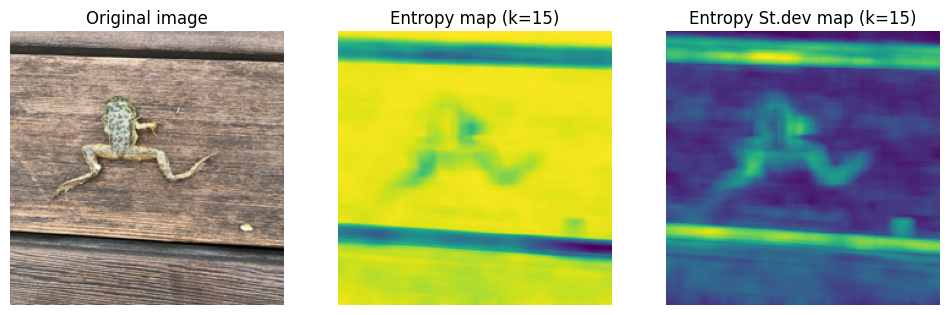

In [10]:
### EntropyPooling testing along with std.dev map given a kernel_size
### The higher the kernel_size the more "blurred" the resulting feature map.

imagename = "frog.jpg"
orig = Image.open(imagename).convert("RGB").resize((224,224))
img  = ttf.to_tensor(orig.convert("L"))

k = 15

# pooling module
#ep = EntropyPool2d(kernel_size = k).to(DEVICE)
#emap = ep(img)

emap = e_pooling(img, k)

# std map
stdmap = entropy_pooling(img, k = k, fun = torch.std)

# plotting
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(emap[0,:,:])
axs[1].set_title(f"Entropy map (k={k})")
axs[1].axis("off")
axs[2].imshow(stdmap[0,:,:])
axs[2].set_title(f"Entropy St.dev map (k={k})")
axs[2].axis("off")
plt.show()

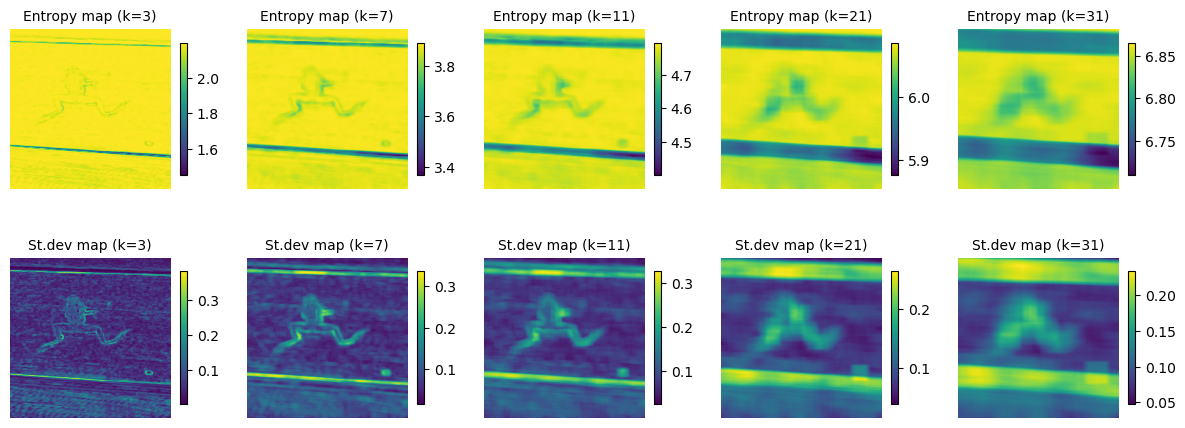

In [ ]:
# precompute the entropy map for a grid of kernel sizes with the purpose
# of displaying it along with std.dev map
tosave = dict()
ks = [3, 7, 11, 21, 31]
for k in ks:
    emap = e_pooling(img, k)
    s = entropy_pooling(img, k=k, fun=torch.std)
    tosave[k] = (emap,s)

# plot
fig, axs = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mat = ax.imshow(tosave[ks[i]][0][0,:,:])
        ax.set_title(f"Entropy map (k={ks[i]})", fontsize=10)

    else:
        mat = ax.imshow(tosave[ks[i-5]][1][0,:,:])
        ax.set_title(f"St.dev map (k={ks[i-5]})", fontsize=10)

    ax.axis("off")
    cbar = fig.colorbar(mat, ax = ax, shrink=0.55)

plt.tight_layout()
plt.show()

### Frequency filtering
This filtering implementation aims to filter the original (gray-scale converted) test image by retaining only those informations belonging to high frequency components that are supposed to better represent image boundaries and fine grained details. The purpose is to extract a feature map that enhance information usually associated to object boundaries and shapes.

For a mask $m \in \{0, 1\}H \times W$ , the low-pass filtering $\mathcal{M}^{S}_l$ and high-pass filtering $\mathcal{M}^{S}_h$
 with the filter size $S$ are formally defined as:

\begin{equation}
% \small
\begin{split}
\mathcal{M}_l^{\!S}\!(x)\! =\! \mathcal{F}^{-\!1}(m\! \odot\! \mathcal{F}(x)),
\ \text{where} \
m_{i,j}\!=\!
\left\{\begin{array}{l}
1, \ \text{if} \  \min(|i\!-\!\frac{H}{2}|,|j\!-\!\frac{W}{2}|)\! \leqslant\! \frac{S}{2} \\
0, \ \text{otherwise}
\end{array}, \right.
\end{split}
\end{equation}

\begin{equation}
% \small
\begin{split}
\!\mathcal{M}_h^{\!S}\!(x)\! =\! \mathcal{F}^{-\!1}(m\! \odot\! \mathcal{F}(x)), \text{where} \
m_{i,j}\!=\!
\left\{\begin{array}{l}
0, \  \text{if} \  \min(|i\!-\!\frac{H}{2}|,|j\!-\!\frac{W}{2}|) \!\leqslant\! \frac{\min(H,W)\!-\!S}{2} \\
1, \ \text{otherwise}
\end{array}\!, \right.
\end{split}
\end{equation}

Where $\mathcal{F}$ and $\mathcal{F}^{-\!1}$ refer to the direct and inverse Fourier Transformation respectively.

The resulting high-pass filtered grayscale test image is then process by the EntropyPooling layer according to some kernel sizes in order to extract the feature map that will be further used to optimize the region proposal search.

REFERENCE
```
@inproceedings{bai2022improving,
  title={Improving Vision Transformers by Revisiting High-frequency Components},
  author={Bai, Jiawang and Yuan, Li and Xia, Shu-Tao and Yan, Shuicheng and Li, Zhifeng and Liu, Wei},
  booktitle={European Conference on Computer Vision},
  year={2022}
}
```


In [11]:
def freq_mask(h,w,s, freq="low"):
    """
    Compute mask estimation according to either "low" or "high"
    frequency pass.
    Args:
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor binary mask
    """
    xc = np.where(abs(np.arange(0, w)-(w/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, w)-(w/2)) <= (min(h,w)-s)/2, 0, 1)
    yc = np.where(abs(np.arange(0, h)-(h/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, h)-(h/2)) <= (min(h,w)-s)/2, 0, 1)
    return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

def freq_filter(img, h,w,s, freq="low"):
    """
    Return the preprocessed frequency map image according to either
    "low" or "high" frequency pass.
    Args:
        img: (torch.tensor) input image
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor
    """
    return torch.tensor(abs(np.fft.ifft2(np.multiply(freq_mask(h,w,s,freq),
                                                    np.fft.fftshift(np.fft.fft2(img))
                                                    )))).unsqueeze(0)

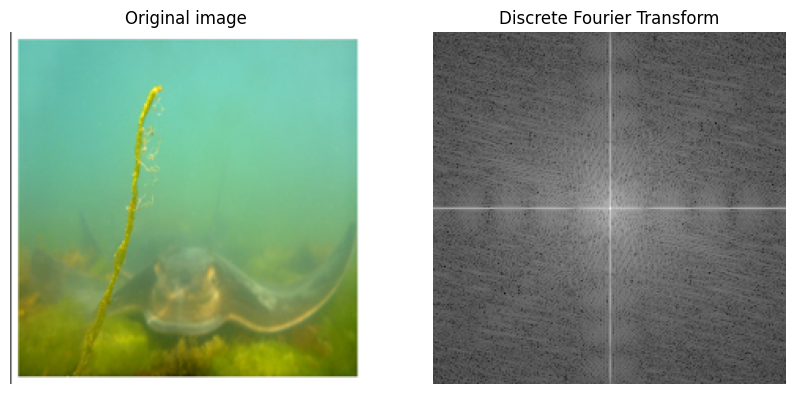

In [12]:
### testing the effect over an image
imgfilename = "imageneta.png"
h,w = (224,224)
orig = Image.open(imgfilename).convert("RGB").resize((h,w))
img  = Image.open(imgfilename).convert("L").resize((h,w))
ftransformed = np.fft.fftshift(np.fft.fft2(img))
inv_ftrasformed = np.fft.ifft2(ftransformed)

# plotting
fig, axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(np.log(abs(ftransformed)), cmap='gray')
axs[1].set_title("Discrete Fourier Transform")
axs[1].axis("off")
plt.show()

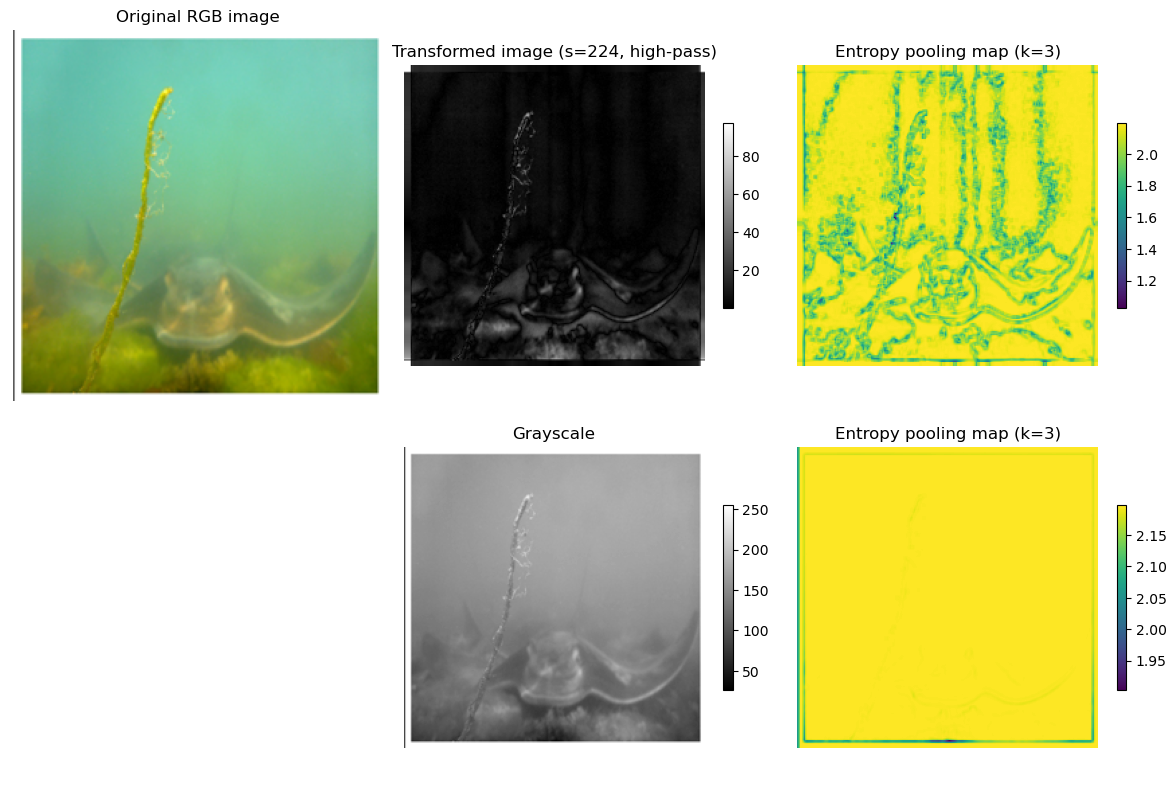

In [ ]:
# Hyperparameters definition
factor = 1            # how much s needs to be reweighted (0=none,1=full)
s      = h * factor   # freq filter size
k      = 3            # entropy pooling kernel size
freq   = "high"       # "low" or "high" pass filtering

freq_filt_img = freq_filter(img, h, w, s, freq)
ep = EntropyPool2d(kernel_size=k).to(DEVICE)

entropy_img_frmap = ep(freq_filt_img)

try:
    entropy_img_map   = ep(ttf.to_tensor(img))
except:
    entropy_img_map   = entropy_pooling(ttf.to_tensor(img), k=k)

fig, axs = plt.subplots(2 , 3, figsize=(12,8))
axs[0][0].imshow(orig)
axs[0][0].set_title("Original RGB image", fontsize=12)
axs[0][0].axis("off")

m1 = axs[0][1].imshow(freq_filt_img[0,:,:], cmap="gray")
axs[0][1].set_title(f"Transformed image (s={round(s)}, {freq}-pass)", fontsize=12)
axs[0][1].axis("off")
cbar = fig.colorbar(m1, ax = axs[0][1], shrink=0.5)

m2 = axs[0][2].imshow(entropy_img_frmap[0,:,:])
axs[0][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[0][2].axis("off")
cbar = fig.colorbar(m2, ax = axs[0][2], shrink=0.5)

#axs[1][0].imshow(orig)
#axs[3].set_title("Original image", fontsize=10)
axs[1][0].axis("off")

m4 = axs[1][1].imshow(img, cmap="gray")
axs[1][1].set_title(f"Grayscale", fontsize=12)
axs[1][1].axis("off")
cbar = fig.colorbar(m4, ax = axs[1][1], shrink=0.5)

m5 = axs[1][2].imshow(entropy_img_map[0,:,:])
axs[1][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[1][2].axis("off")
cbar = fig.colorbar(m5, ax = axs[1][2], shrink=0.5)

plt.tight_layout()
plt.show()

"As shown above, the entropy pooling outputs yield different feature maps. The differences are provided by using the grayscale approach or by transforming the image, whilst controlling the kernel size of the pooling layer.

We expect the feature maps to output their search process in different regions, enabling the output to be more varied???"

### #?
(Motivo del dubbio: le frasi sono molto lunghe e in inglese perdono il loro senso. Si capisce che è la stessa immagine. Non si capisce invece su cosa dovrebbero convergere le due mappe (se finiscono su aree diverse stanno divergendo, no?). Altro punto dubbio è nell'ultima frase, cioè non è esplicito il punto; l'ipotesi a cui si sta alludendo è che useremo entrambi gli approcci perché provvedono a diverse aree della foto?
Sopra provo a riordinare la spiegazione tra virgolette )

The entropy pooling outputs resulting from the two approaches tested over the same image as above an by fixing the kernel_size of the pooling layer, are yielding different feature maps. One may expect then that the search process over those feature maps would converge over different regions, enabling to differently explore the space of cropping regions.

### Covariance Matrix Adaptation - Evolutionary Strategy (CMA-ES for short)
"CMA-ES is an algorithm for numerical optimization that does not require parameter tuning nor gradients. It estimates a covariance matrix on convex-quadratric functions, providing several invariance properties for less computation. Its purpose in our project is to search the feature space to obtain a region of maximum information. The authors define it as "an evolutionary algorithm for difficult non-linear non-convex black-box optimisation problems in continuous domains" ([CMA Evolution Strategy](https://cma-es.github.io/)).

Its ability to evolve solutions - in our domain we use solutions to mean selected regions of the input - in an efficient manner is the reason we are applying it to pre-process  [è giusto chiamare questa fase pre-processing? la butto lì come parola] image data."  

(Qui sarebbe utile parlare nel dettaglio di come CMA-ES serve per estrarre un sottoinsieme della foto usando CropInstance)
(Ho notato che anziché mettere una reference con riferimento a ipertesto / link metti "REFERENCE" e basta; nel caso non lo sapessi, puoi usare il markdown delle celle per mettere un link usando questa struttura (senza spazi tra elementi):


[ testo da mostrare ]  (LINK AL PAPER )

)

### #?
(La spiegazione qui sotto è composta da un periodo molto lungo che sta un pò a metà tra lo spiegare la definizione del CMA-ES e la sua rilevanza nel progetto. Propongo, tra virgolette qui sopra, di parlare dapprima di cos'è in breve e poi di spiegare perché è rilevante, così chi legge non deve fare lo sforzo di capire il ruolo. Ci sono circa 3 o 4 punti fondamentali per spiegare cos'è CMA-ES nella spiegazione degli autori che ho linkato sopra, possiamo scegliere quali sono più rilevanti)


CMA-ES is an algorithm that efficiently evolves solutions over a continuous search space by progressively optimizing the direction of new offsprings by considering the covariance matrix of e whole population at each generation.

REFERENCE

The current chunk initialise a `CropInstance` class which will deal with the size of candidate bounding boxes to adapt them by checking whether sizes respect certain thresholds.

In [14]:
class CropInstance():
    """
    Normalised Crop instance (region proposal) over a given target image
    """
    def __init__(self, x: float, y: float, w: float, h: float, imgsize: tuple):
        assert 0 <= x < 1 and 0 <= y < 1, "Cropping point out of bound!"
        assert 0 <= w <= 1 and 0 <= h <= 1, "Bounding dimension out of bound!"
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.imgsize = imgsize
        self.xlim, self.ylim = 1, 1
        self.w_min, self.h_min = 1/6, 1/6  # or even 1/5
        # check for min/max bounds
        self.w = self.w if self.w > self.w_min else self.w_min
        self.x = self.xlim - self.w if self.x + self.w > self.xlim else self.x
        self.h = self.h if self.h > self.h_min else self.h_min
        self.y = self.ylim - self.h if self.y + self.h > self.ylim else self.y
        # final check: consider to delete this section
        assert self.x + self.w <= self.xlim, "Cropping bounding box out of bound! (x axis)"
        assert self.y + self.h <= self.ylim, "Cropping bounding box out of bound! (y axis)"

        # integer conversion
        self.xint, self.yint, self.wint, self.hint = tuple(
            map(round,
                [self.x * self.imgsize[0],
                 self.y * self.imgsize[1],
                 self.w * self.imgsize[0],
                 self.h * self.imgsize[1]]
               )
        )
    def __str__(self):
        return  "-------------------- (x)    (y)    (w)    (h)\n"+ \
         f"fixed coords:  float: {self.x:.4f} {self.y:.4f} {self.w:.4f} {self.h:.4f}\n"+ \
         f"               int  : {(self.xint, self.yint, self.wint, self.hint)}"

In [15]:
ci = CropInstance(0.90, 0.95, 0.1, 0.001, (224,224))
print(ci)

-------------------- (x)    (y)    (w)    (h)
fixed coords:  float: 0.8333 0.8333 0.1667 0.1667
               int  : (187, 187, 37, 37)


### Augmenter
Displaying *Autoaugmentation* examples as in [REFERENCE] explain the RL-based augmentation search learned over the ImageNet dataset.

Specify (Maybe) that if you want to be really out-of-the-box the augmentation policy needs to be tuned differently including random policies: since it may be biased with respect to the original dataset on which it had been originally implemented (Imagenet).

In [16]:
def get_augmenter():
    """ Return AutoAugmenter policy pre-optimized over IMAGENET
    """
    return v2.Compose([
        v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.RandomHorizontalFlip(p=0.5),
        ]).to(DEVICE)

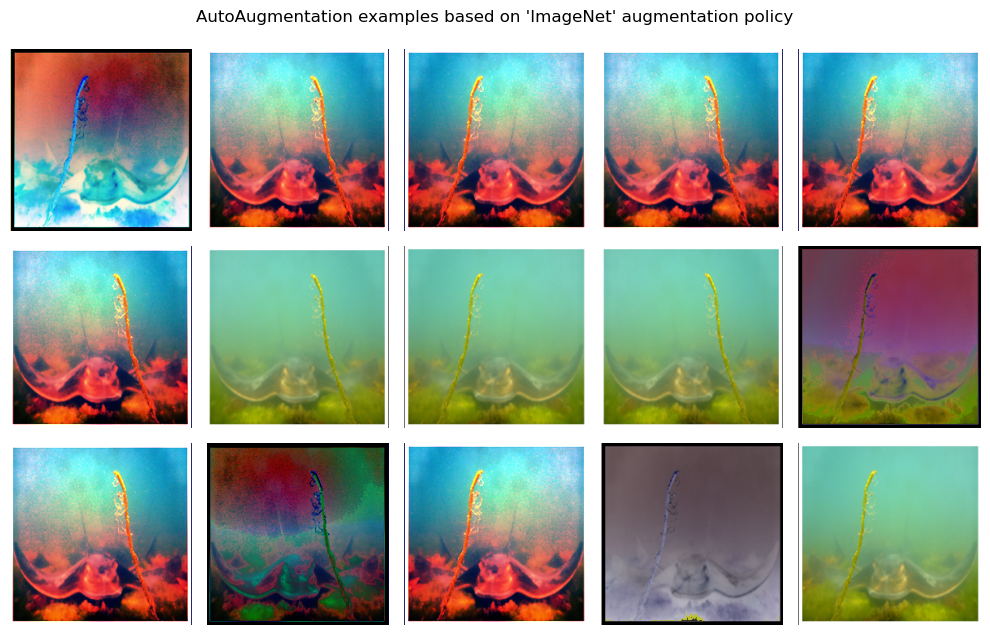

In [ ]:
img = Image.open("imageneta.png").convert("RGB").resize((224,224))
augmenter = get_augmenter()

fig, axs = plt.subplots(3,5, figsize=(10,6.5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow((augmenter(img)))
    ax.axis("off")

plt.suptitle("AutoAugmentation examples based on 'ImageNet' augmentation policy")
plt.tight_layout()
plt.show()

### Load and test Super Resolution (SR) model
(In this section, the purpose of increasing the resolution of an image is to allow _any classifier to better focus on the details from a previously selected region_. We load a pre-trained image restoration model ([SwinIR](https://github.com/JingyunLiang/SwinIR)) that puts to use Transformers.  
#### # ?
(ho tentato di commentare in che modo viene usato SR in questo processo; in corsivo evidenzio la parte sulla quale ho più dubbi)

In [17]:
# clone repo
if not os.path.exists("SwinIR"):
    !git clone https://github.com/JingyunLiang/SwinIR.git

# load pretrained model params
if not os.path.exists("experiments"):
    !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 333 (delta 6), reused 5 (delta 2), pack-reused 320
Receiving objects: 100% (333/333), 29.84 MiB | 37.63 MiB/s, done.
Resolving deltas: 100% (119/119), done.
--2024-06-27 14:09:59--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/396770997/f3c0fbd1-d787-49f1-924a-8939e9a6707c?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20240627%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20240627T140959Z&X-Amz-Expires=300&X-Amz-Signature=009db970fc53d6e60cc8cc8bcc5a742f057c5a14a901f13764a9

`sr_run` will run the image upscaling by either performing a fullpass or by splitting the original image into tiles and run the model on each tile.

In [18]:
from SwinIR.models.network_swinir import SwinIR as net

def get_sr_model():
    ''' Return SR model
    '''
    # state dict specification
    param_key_g = 'params_ema'
    model = net(upscale=4, in_chans=3, img_size=64, window_size=8,
                img_range=1., depths=[6, 6, 6, 6, 6, 6],
                embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                mlp_ratio=2, upsampler='nearest+conv', resi_connection='1conv')
    model = model.to(DEVICE)
    pretrained_model = torch.load("experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
    model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
    return model


def sr_run(lr_image, model, sf, tile, overlap, verbose=True):
    """ Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
    Upscale image by Super Resolution according to a scale factor (sf).
    Args:
        lr_image: (PIL image) Low Resolution image to be upscaled
        model: (torch.nn.Module) super resolution model
        sf: (int) scale factor, (default: 4)
        tile: (int) tile size while splitting the SR run (default: 32, 64)
        overlap: (int) pixel overlap
    Return:
        sr_image (torch.Tensor) of dims: (1, c, h, w) Super Resolution image
    """
    lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

    print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

    model.eval()

    b, c, h, w = lr_image.size()

    fullImagePass = True if min(h, w) <= tile else False

    # test the image without tiling (single full pass)
    if fullImagePass:
        print(" - full pass LR image") if verbose else None
        with torch.no_grad():
            sr_image = model(lr_image.to(DEVICE))

    # unfold and process the image tile by tile (multiple subset pass)
    else:
        if verbose:
            print(" - Unfolding LR image...")
        assert tile < min(h,w), "Tile must be less than imagesize (h,w) "

        # Collect tiles
        stride = tile - overlap
        h_ids = [i for i in range(0, h - tile, stride)]
        w_ids = [j for j in range(0, w - tile, stride)]
        h_ids.append(h - tile)
        w_ids.append(w - tile)
        h_idx_list = list(range(0, h - tile, stride)) + [h - tile]
        w_idx_list = list(range(0, w - tile, stride)) + [w - tile]

        # Init output of zeros
        E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
        W = torch.zeros_like(E)

        # Unfold and perform sr over patches
        for h_id in h_ids:
            for w_id in w_ids:
                in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]

                with torch.no_grad():
                    out_patch = model(in_patch.to(DEVICE))

                out_patch = out_patch.to(DEVICE)
                out_patch_mask = torch.ones_like(out_patch)
                E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
        sr_image = E.div_(W)

    return sr_image

In [19]:
# select image:
x = ttf.to_tensor(Image.open("frog.jpg").convert("RGB").resize((56,56))).unsqueeze(0)

x = x.to(DEVICE)
srmodel = get_sr_model()
sr = sr_run(x, srmodel, sf=4, tile=32, overlap=4)

#print("input:  ",x.shape)
#print("output: ",sr.shape)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    LR image size: torch.Size([1, 3, 56, 56])  - Unfolding LR image...


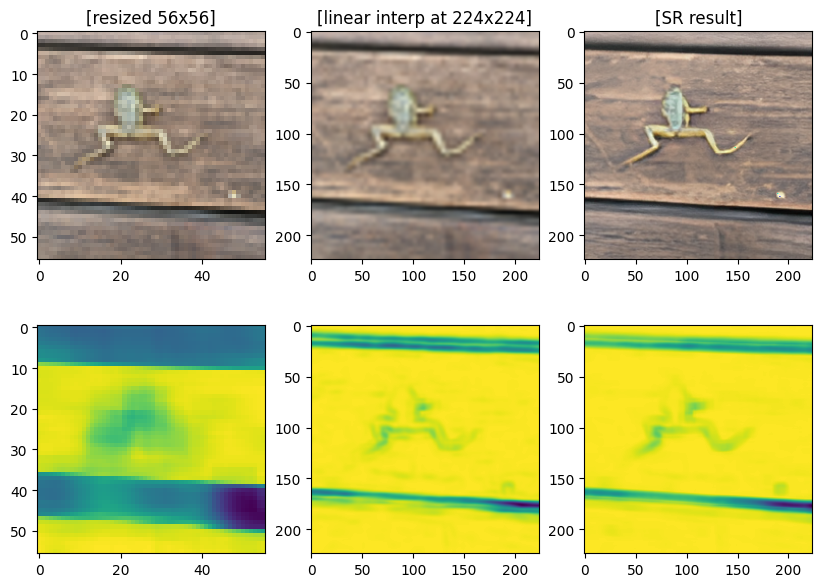

In [20]:
kernel_size = 11

fig, ax = plt.subplots(2,3,figsize=(10,7))

ax[0,0].imshow(ttf.to_pil_image(x.squeeze(0)))
ax[0,0].set_title("[resized 56x56]")
ax[0,1].imshow(ttf.to_pil_image(x.squeeze(0)).resize((224,224)))
ax[0,1].set_title("[linear interp at 224x224]")
ax[0,2].imshow(ttf.to_pil_image(sr.squeeze(0)))
ax[0,2].set_title("[SR result]")

ax[1,0].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).convert("L")), kernel_size).squeeze(0))
ax[1,1].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).resize((224,224)).convert("L")), kernel_size).squeeze(0))
ax[1,2].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(sr.squeeze(0)).convert("L")), kernel_size).squeeze(0))

plt.show()

SR has executed (as expected) the task properly. (Linear interpolation è comunque parte di SR, corretto? o è un metodo che viene chiamato per fare un paragone? E la "resized" image è semplicemente l'originale senza che sia stata passata sotto CMA-ES # ?  )

### Optimizer definition according to backbone
(_rephrasing for simplicity_:

In this section, we test the contribution of CMA Evolutionary Strategy to the quality of the classification using MEMO Test Time robustness via Adaptation and Augmentation.We load each optimizer according to [Zhang et. al, (2022)](https://openreview.net/pdf?id=vn74m_tWu8O). The backbones used have been tested with a specific optimizer.

- `ResNet50`: tested with Stocastic Gradient Descent (`lr = 0.00025`, `weight_decay = 0.0`)
- `RVT*-small`, `ResNet101` (and `ViT`): tested with AdamW (`lr = 0.00001`, `weight_decay = 0.01`)

  
)


In order to check whether the Evolutionary approach here presented provides some advantage over MEMO TTA the following chunk aims at loading each optimizer used as in the reference paper. Each backbone had been tested via a specific optimizer, namely:
- `ResNet50`: Stocastic Gradient Descent (`lr = 0.00025`, `weight_decay = 0.0`)
- `RVT*-small`, `ResNet101` (and `ViT`): AdamW (`lr = 0.00001`, `weight_decay = 0.01`)

In [21]:
def get_optimizer(backbonename, model):
    """ Return the optimizer used as in reference paper according to backbone
    """
    if backbonename == "resnet":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.00025, weight_decay=0.0)
    elif backbonename in ("resnet101", "vit", "rvt"):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)
    return optimizer

In [22]:
os.system("echo $CUDA_HOME")

0

### Download Grounding DINO [TO-DO]
For zero-shot learning: grounding DINO offers a prompt based zero-shot object detection able to detect objects belonging to previously unseen classes on which it had not been explicitly trained.

Adapt the implementation via the below chunk made bby `transformers` and download the `tiny` version.

In [140]:
####
# ADAPTING GROUNDING DINO from Transformers
####

import requests
from PIL import Image
from transformers import AutoProcessor, GroundingDinoForObjectDetection

url   = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text  = "a cat."

# loading DINO text and box processor and model
processor  = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
dinomodel = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny").to(DEVICE)

In [141]:
from torchvision.ops import box_convert

def zeroshot_obj_detect(model, processor, image, promt, box_threshold = 0.3,
                        text_threshold = 0.1):
    '''
    Return boxes and confidence
    '''
    device = next(model.parameters()).device  # Ho aggiunto questo come soluzione a un'errore che veniva di "found multiple devices (cuda:0 and cpu)"
    inputs = processor(images = image, text = promt, return_tensors = "pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}   # Questo passa ogni valore al device

    # find a way to put image into cuda / Fatto (penso?)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    target_sizes = torch.tensor([image.size[::-1]]).to(device)  #qua ho aggiunto .to(device)
    #results = processor.image_processor.post_process_object_detection(
    #    outputs, threshold=0.35, target_sizes=target_sizes)[0]

    results = processor.post_process_grounded_object_detection(
        outputs,
        input_ids=inputs["input_ids"],
        box_threshold=box_threshold,
        text_threshold=text_threshold)[0]

    return results["boxes"], results["scores"]

boxes, logits = zeroshot_obj_detect(dinomodel,
                        processor,
                        image=Image.open("frog.jpg").resize((100,100)),
                        promt="animal . object . reptile .")

In [142]:
# sort by confidence

confidence = 1
tmp = sorted([(logits[i].item(), boxes[i,:]) for i in range(logits.shape[0])],
                key = lambda x: x[0], reverse=True)

sorted_logits = torch.tensor([logit for logit, _ in tmp])
logits = sorted_logits[0:round(sorted_logits.shape[0] * confidence)]
prob_sampling = (logits/logits.sum()).numpy()

sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)
sorted_boxes = sorted_boxes[0:logits.shape[0], :]
sample = np.random.choice(range(0, logits.shape[0]), size = 10,
                          replace=True, p=prob_sampling)
boxes = sorted_boxes[sample, :]

w,h = (100,100)
# convert from "xyxy" to "xywh" format (integer values)
xywh = box_convert(boxes = boxes.to("cpu") * torch.Tensor([w, h, w, h]),
            in_fmt="xyxy", out_fmt="xywh").numpy()


cbb  = [tuple(xywh[i,j] for j in range(xywh.shape[-1]))\
            for i in range(xywh.shape[0])]


###
bname = "resnet"

# dataloader initialization
hparams = {
    "mode": "model", "Ntrials": 5, "popSize": 16,
    "kernel_size": 3, "enableSR": False,
    "enableAugm": True,
}

dino_hparams = {
        "prompt": "animal . reptile . object",
        "text_thr": 0.35,
        "box_thr": 0.10,
        "confidence": 1,
}

img = ttf.to_tensor(Image.open("frog.jpg").convert("RGB").resize((224,224)))
label = "frog"

model = backbone_loading(bname)
srmodel = get_sr_model()
augmenter = get_augmenter()
loss_function = EntropyLoss()
optimizer = get_optimizer(bname, model)

# run for Imagenet-A
evotta = EvoTTA(img,
                label,
                bname,
                model,
                srmodel,
                dinomodel,
                hparams,
                dino_hparams,
                augmenter,
                loss_function,
                optimizer,
                imgsize=(224,224), sr_ratio=0.33, n_classes=1000)

evotta.zeroshot_obj_detect()

<ipython-input-142-a799f63bc8b6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)


Loading backbone (resnet): Done.


NameError: name 'zeroshot_object_detect' is not defined

## Testing the learning procedure

### S3 bucket implementation

(_rephrasing_

Setting the __getitem__ method changes the transformations that are applied.

)


Check out the  `__getitem__` method in which the transformations are applied. **Open question**: shall we also normalise accordinig to Imagenet mean/std?  

(I believe that we should. It's absolutely a good practice to standardize the feature space. More so # ? )

In [122]:
class S3ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, folder_to_labels, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Maps Imagenet-A folder name into label to yeild the test image label
        self.folder_to_labels = folder_to_labels

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"])
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm",
                ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            foldername, key = self.instances[idx]

            # folder name to label conversion
            label = self.folder_to_labels[foldername]

            # Download image from S3
            response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
            img_bytes = response["Body"]._raw_stream.data

            img_bytes = BytesIO()
            response = self.s3_client.download_fileobj(Bucket=self.s3_bucket,
                                                       Key=key, Fileobj=img_bytes)
            #img_bytes = response["Body"]._raw_stream.data

            # Open image with PIL
            img = torchvision.transforms.functional.to_tensor(Image.open(img_bytes)\
                                                              .convert("RGB")\
                                                              .resize((224,224)))
            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)

        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, label


def get_dataloader(batch_size, img_root, workers=1, transform=None):
    """ Return the imagenet-a dataloader instance """
    dataset = S3ImageFolder(root=img_root,
                            folder_to_labels=FOLDERS,
                            transform=transform)
    return torch.utils.data.DataLoader(dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=workers)


### Second implementation (of what#? it's explicit _with_ what but not _of_ what) with 'Obj' instances
We summarise (in pseudocode) the two classes used in this section.

- `EvoTTA` manages the single image processing and inference phase by performing:
    1. **if `evoProposal=True`**:
       - batch generation by evolutionary guided procedure (`evolve` method)
    2. **if `hparams["enableSR"]=True`**:
       - super resolution region proposal upsampling (`high_res` method)
         
    3. **Test Time Adaptation**
       - `trainIter` trains over mininimizing the Entropy loss function (`single_test_time_adaptation`) method.  that returns `batch, cum_prob, cum_loss`, the final batch of cropped and augmented images, the cumulative prob and loss).
    
- `EvalEvoTTA`runs the full TTA procedure and accuracy evaluation for a given set of hyperparms. (`run_single_hset`)




### # ?
(La versione che ti ho scritto sopra non è esattamente pseducodice. Usando le regole comuni dello pseudocodice sarebbe più così) :
```
Procedure EvoTTA(image, evoProposal, hparams)
    # Step 1: Evolutionary Proposal
    if evoProposal is True then
        # Generate batch using evolutionary guided procedure
        batch = evolve (image)

    # Step 2: Super Resolution
    if hparams["enableSR"] is True then
        # Image recovery to upsample the region proposal
        batch = high_resolution (batch)

    # Step 3: Test Time Adaptation
    # Iter training ONCE to minimize Entropy loss function
    batch, cum_prob, cum_loss = single_test_time_adaptation (batch)

    # Step ?4?: DINO
    # Qui non ho ancora inserito cosa fa
    
    # Return the final results
    return batch, cum_prob, cum_loss
End Procedure

```

In [143]:
import os
import csv
import time
import itertools

class EvoTTA(object):
    '''
    Structure that will manage the evolutionary search, augmentation
    and inference procedure by performing an "episodic" learning stage at
    inference time.
    '''
    def __init__(self, image, label, backbonename, model, srmodel, dinomodel,
                 processor, hparams, dino_hparams, augmenter, loss_function,
                 optimizer, imgsize=(224,224), sr_ratio=0.33, n_classes=1000):

        self.image = image
        self.label = label
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel
        self.dinomodel = dinomodel
        self.processor = processor

        self.mode        = hparams["mode"]
        self.Ntrials     = hparams["Ntrials"]
        self.popSize     = hparams["popSize"]
        self.kernel_size = hparams["kernel_size"]
        self.enableSR    = hparams["enableSR"]
        self.enableAugm  = hparams["enableAugm"]

        self.prompt      = dino_hparams["prompt"]
        self.text_thr    = dino_hparams["text_thr"]
        self.box_thr     = dino_hparams["box_thr"]
        self.confidence  = dino_hparams["confidence"]

        self.augmenter     = augmenter
        self.loss_function = loss_function
        self.optimizer     = optimizer
        self.imgsize       = imgsize
        self.sr_ratio      = sr_ratio

        self.cache = dict()
        self.n_classes = n_classes

    #-------------------------------------------------------------------------------
    # *** General class utility functions
    #-------------------------------------------------------------------------------

    def init_cache(self):
        '''
        Cache initialisation storing evo-derived region proposal performance
        '''
        if self.cache == dict():
            self.cache = {"best_fit":np.zeros((self.Ntrials)),
                         "avg_fit":np.zeros((self.Ntrials)),
                         "std_fit":np.zeros((self.Ntrials)),
                         "median_fit":np.zeros((self.Ntrials)),
                         "worst_fit":np.zeros((self.Ntrials)),
                         "cand_solutions":[],
                         "best_solutions":[],
                         }

    def update_cache(self, generation, value, phenotype):
        '''
        Update the optimization performance logs
        '''
        self.cache["best_fit"][generation] = torch.min(value).item()
        self.cache["avg_fit"][generation] = torch.mean(value).item()
        self.cache["std_fit"][generation] = torch.std(value).item()
        self.cache["median_fit"][generation] = torch.median(value).item()
        self.cache["worst_fit"][generation] = torch.max(value).item()
        self.cache["cand_solutions"].append(phenotype)
        self.cache["best_solutions"].append(phenotype[torch.argmin(value).item()])

    def plot_performance(self):    # ? È stato mai usato questo metodo? Non trovo l'applicazione, ma sembra molto molto carino
        '''
        Plot fitness values along generations
        '''
        plt.figure(figsize=(10,5))
        plt.plot(self.cache["best_fit"],\
            color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["worst_fit"],\
            color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["median_fit"],\
            color="black", label="median", linewidth=1.15, alpha=0.3)
        plt.plot(self.cache["avg_fit"],\
            color="blue", label="avg", linewidth=1.15)
        plt.plot(self.cache["avg_fit"]+self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.plot(self.cache["avg_fit"]-self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.fill_between(range(0, self.Ntrials),\
            self.cache["avg_fit"]+self.cache["std_fit"],\
            self.cache["avg_fit"]-self.cache["std_fit"],\
            alpha=0.1)
        plt.suptitle("CMA-ES performance")
        plt.ylabel("Region proposal avg entropy")
        plt.xlabel("Generation")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def show_crop_results(self, img):
        '''
        Plot Cropping regions according to generations
        '''
        gens = [1] + list(range(10, self.Ntrials+1, 10))
        fig, axs = plt.subplots(3, 3, figsize=(12,8))
        fig.suptitle(f"Cropping regions over generations (k={self.kernel_size})", fontsize=14)

        for i, ax in enumerate(axs.flatten()):
            try: ax.imshow(np.asarray(img))
            except: ax.imshow(ttf.to_pil_image(img))
            for cbb in self.cache["cand_solutions"][gens[i]-1]:
                ax.add_patch(
                    patches.Rectangle((cbb.xint, cbb.yint),
                                       cbb.wint, cbb.hint,
                                       linewidth=0.9,
                                       edgecolor='r',
                                       facecolor='none'))
            ax.axis("off")
            ax.set_title(f"Gen: {gens[i]}")
        plt.show()

    #-------------------------------------------------------------------------------
    # *** TTA utility functions:
    #-------------------------------------------------------------------------------

    @staticmethod
    def entropyModelFitness(model, batch):
        '''
        Compute entropy of the cropped images organised in batch (n_item, c, w, h)
        '''
        batch = batch.to(DEVICE)

        model.eval()
        with torch.no_grad():
            outputs = model(batch)
            probs   = torch.softmax(outputs, -1)
            return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

    @staticmethod
    def entropyMapFitness(phenotype, imgsize, alpha=0.001, epsilon=10**(-5)):
        '''
        Compute the fitness of a cropped entropy / frequency-entropy map
        by estimating the mean entropy value over the area, penalized by the
        region size (the higher the better).
        '''
        h, w = phenotype.shape[1:]
        h_ref, w_ref = imgsize
        return phenotype.mean() + alpha * (1 / ((h/h_ref) * (w/w_ref) + epsilon))

    @staticmethod
    def get_fmap(img, kernel_size, verbose=False):
        '''
        Feature map estimation by performing entropy pooling over
        the baseimage.
        '''
        t0 = time.time()

        try:
            img = img.to(DEVICE)
            fmap = e_pooling(img, kernel_size)
        except:
            fmap = entropy_pooling(img, kernel_size, fun=entropy)

        t1 = time.time()
        print("E-pooling elapsed: ", round(t1-t0, 3)) if verbose else None
        return fmap.to("cpu")

    @staticmethod
    def resize_crop(img, x, y, w, h, target_dim):
        '''
        Return the unsqueezed, cropped and resized image converted into tensor
        '''
        if target_dim != None:
            resized = ttf.to_tensor(ttf.crop(img, y, x, h, w)\
                .resize(target_dim))\
                .unsqueeze(0)
        else:
            resized = ttf.crop(img, y, x, h, w)
        return resized

    @staticmethod
    def into_batch(img, phenotype, sample, mode, imgsize):
        '''
        Return a batch of region proposal instances converted into tensor
        of size (nItems, nChannel, H, W)
        '''
        if mode == "model":
            batch = torch.cat(phenotype, 0) # concat tensors whose dims are (1, c, h, w)

        elif mode in ("emap", "freqmap"):
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], imgsize)\
                        for s in sample]
            batch   = [EvoTTA.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, imgsize)\
                        for cbb in cand_bb]
            batch   = torch.cat(batch, 0)

        return batch

    @staticmethod
    def augment(augmenter, sample):
        '''
        Perform data augmentation via augmenter obj
        '''
        return torch.cat([augmenter(s).unsqueeze(0) for s in sample], 0)

    @staticmethod
    def get_pred_label(cum_prob, nclass2label, how="avg"):
        '''
        Return the confidence of the predicted label at inference time according
        to either ('avg' or 'max') conditions
        Args:
            cum_prob: (torch.Tensor) of prediction confidence (n_epoch, n_istance, n_classes)
            nclass2label: (dict) object that maps class number to original Imagenet_1k class names
            how: (str) way to compute prediction ('max', 'avg')
        Return:
            class label, class number, confidence level
        '''
        assert how in ("max", "avg"), "Options allowed: ('max', 'how')"
        if how == "max": # Remove
            raise NotImplementedError
            #confidence, class_n = cum_prob[-1,:,:].max().item(), cum_prob[-1,:,:].argmax().item()
        elif how == "avg":
            confidence = cum_prob[-1,:,:].mean(0).max().item()
            nclass = cum_prob[-1,:,:].mean(0).argmax().item()
            label = nclass2label[nclass]
        return label, nclass, confidence

    @staticmethod
    def sr_run(lr_image, srmodel, sf, tile, overlap, verbose=False):
        '''
        Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
        Args:
            lr_image: (PIL image) low resolution image to be upscaled
            srmodel: (torch.nn.Module) superresolution model
            sf: (int) Scaling Factor, (default: 4)
            tile: (int) tile size while splitting the SR run (default: 128)
            overlap: (int) pixel overlap
        Return:
            sr_image (torch.Tensor) dims: (1, c, h, w)
        '''
        lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

        print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

        srmodel.eval()

        b, c, h, w = lr_image.size()

        # (full image pass condition): test the image without unfolding in tiles
        if min(h, w) <= tile:
            print(" - Full pass LR image") if verbose else None
            with torch.no_grad():
                lr_image = lr_image.to(DEVICE)
                sr_image = srmodel(lr_image)

        # unfold and process test image by tiles
        else:
            assert tile < min(h,w), "Tile must be less than imagesize (h,w)."
            print(" - Unfolding LR image") if verbose else None
            stride = tile - overlap
            h_ids = [i for i in range(0, h - tile, stride)] + [h - tile]
            w_ids = [j for j in range(0, w - tile, stride)] + [w - tile]

            # Init output of zeros
            E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
            W = torch.zeros_like(E)

            # Unfold and perform sr over patches
            for h_id in h_ids:
                for w_id in w_ids:
                    in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]
                    in_patch = in_patch.to(DEVICE)
                    with torch.no_grad():
                        out_patch = srmodel(in_patch)
                    out_patch = out_patch.to("cpu")
                    out_patch_mask = torch.ones_like(out_patch)
                    E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                    W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
            sr_image = E.div_(W)

        return sr_image

    @staticmethod
    def zeroshot_obj_detect(model, processor, image, prompt, box_threshold,
                            text_threshold):
        '''
        Perform visual grounding obj detection given a prompt and box/text thresholds
        Args:
            model: grounding Zero-Shot obj detection model instance
            processor: (transformers.AutoProcessor)
            image: (torch.Tensor)
            prompt: (str) prompt obj detection instructions
            box_threshold: (float) confidence level to accept candidate bounding box
            text_threshold: (float) confidence level to accept candidate bounding box label
        Return boxes and confidence
        '''
        device = next(model.parameters()).device  # Ho aggiunto questo come soluzione a un'errore che veniva di "found multiple devices (cuda:0 and cpu)"
        inputs = processor(images = image, text = prompt, return_tensors = "pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}   # Questo passa ogni valore al device

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        # convert outputs (bounding boxes and class logits) to COCO API
        target_sizes = torch.tensor([image.size[::-1]]).to(device)  #qua ho aggiunto .to(device)

        results = processor.post_process_grounded_object_detection(
            outputs,
            input_ids=inputs["input_ids"],
            box_threshold=box_threshold,
            text_threshold=text_threshold)[0]

        return results["boxes"], results["scores"]


    #-------------------------------------------------------------------------------
    # *** TTA main functions:
    #-------------------------------------------------------------------------------

    def high_res(self, img, cand_bb, sf=4, tile=128, overlap=4):
        '''
        Trying first a simple approach that convert into a super res image according
        to a given criterion (individually, not in batch, while performing the full pass)
        Args:
            img:
            cand_bb:
            ratio: (float) (default = 0.33)
        Return:
            batch (list) of sr_images rescaled by a scale factor of 4 (default)
        '''
        batch = []
        h, w = self.imgsize

        for cbb in cand_bb:

            # check for minimum area elegibility
            if cbb.wint * cbb.hint <= (w*h) * self.sr_ratio:

                # region proposal extraction
                cropped = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)

                # performing upscaling
                cropped = self.sr_run(cropped, self.srmodel, sf, tile, overlap).squeeze(0)
                rescaled = ttf.to_tensor(ttf.to_pil_image(cropped).resize(self.imgsize)).unsqueeze(0)

            # rescaling to model size if region proposal area is > ratio
            else:
                rescaled = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)

            batch.append(rescaled) # list of tensor (1, c, h, w)
        return batch


    def evolve(self, verbose=False, display=False):
        '''
        Perform augmentation search in order to crop test image areas by
        minimising the objective function according to the 'mode' ('model', 'emap',
        'freqmap') approach.

        Return:
            batch: torch.Tensor of dim (n_items, n_channel, h, w).
            solutions: (array) (solution_i, fitness_i) of the i-th evolved instance.
            cache: (dict) performance log.
        '''
        self.init_cache()

        # preprocess test image and extract feature map if mode in ("emap", "freqmap")
        orig = ttf.to_pil_image(self.image.squeeze(0))

        if self.mode == "model":
            img = orig

        elif self.mode == "emap":
            img = ttf.to_tensor(ttf.resize(orig.convert("L"), self.imgsize))
            fmap = self.get_fmap(img=img,
                                 kernel_size=self.kernel_size)

        elif self.mode == "freqmap":
            img = ttf.resize(orig.convert("L"), self.imgsize)
            fmap = self.get_fmap(img=freq_filter(img, self.imgsize[0], self.imgsize[1], self.imgsize[1], freq="high"),
                                 kernel_size=self.kernel_size)

        # CMA-ES Optimizer "ask-and-tell"-style instance initialization
        # search space in 4 dimensions (bounding box x0, y0, h, w parameters)
        optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]),
                          sigma = 0.1,
                          bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                          population_size = self.popSize,
                          seed = np.random.randint(0, 10**5),
                          lr_adapt=True)

        # evolving over generations
        for generation in range(self.Ntrials):

            # draw the current generation sample
            sample =  [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

            # convert each candidate solution into a CropInstance bounding box
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], self.imgsize) for s in sample]

            # region proposal search by model prediction confidence
            if self.mode == "model":
                phenotype = self.high_res(img, cand_bb) if self.enableSR \
                            else [self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)\
                                  for cbb in cand_bb] # list of tensor (1, c, h, w) to be concatenate over axis 0
                batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)
                value = self.entropyModelFitness(self.model, batch)

            # region proposal search by low level visual information entropy minimization
            elif self.mode in ("emap", "freqmap"):
                phenotype = [self.resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)\
                             for cbb in cand_bb]
                value = torch.tensor([self.entropyMapFitness(instance, self.imgsize).item()\
                             for instance in phenotype])

            # Eval and draw new solutions
            solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
            optimizer4d.tell(solutions)

            # Update cache
            self.update_cache(generation, value, cand_bb)

            if verbose:
                if (generation+1) % 1 == 0 or generation == 0:
                    print(f"  gen: {generation+1:3d}/{self.Ntrials}  -"+
                          f"  best: {self.cache['best_fit'][generation]:.6f}  -"+
                          f"  avg: {self.cache['avg_fit'][generation]:.6f}")

        # Checking for upscaling in entropy map conditions
        if self.mode in ("emap", "freqmap"):
            #print("  Entropy map condition: SR of region proposal") if self.enableSR else None
            phenotype = self.high_res(orig, cand_bb) if self.enableSR else phenotype
            batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)

        # Displaying fitness optimization and crop results
        if display:
            self.plot_performance()
            if self.mode == "model":
                self.show_crop_results(self.image)
            elif self.mode in ("emap", "freqmap"):
                self.show_crop_results(fmap[0,:,:])

        return batch, cand_bb, solutions


    def zeroshot_region_proposal(self):
        '''
        Region proposal generation by Grounding DINO zero-shot-object detection
        estimation via text prompt.
        '''
        # percentage
        #xywh_perc = box_convert(boxes = boxes, in_fmt="cxcywh", out_fmt="xywh").numpy()
        #bbperc    = [tuple(xywh_perc[i,j] for j in range(xywh_perc.shape[-1]))\
        #            for i in range(xywh_perc.shape[0])]

        # Zero-shot bounding box prediction
        boxes, logits = self.zeroshot_obj_detect(self.dinomodel,
                                                self.processor,
                                                self.image,
                                                self.prompt,
                                                self.box_thr,
                                                self.text_thr)
        # Bounding box generation
        w, h = self.imgsize

        # sort by confidence
        tmp = sorted([(logits[i].item(), boxes[i,:]) for i in range(logits.shape[0])],
                        key = lambda x: x[0], reverse=True)

        # select top n proposal according to confidence (amount of obs to retain)
        sorted_logits = torch.tensor([logit for logit, _ in tmp])
        logits = sorted_logits[0:round(sorted_logits.shape[0] * self.confidence)]

        # define a vector of probability according to which solutions will be sampled
        prob_sampling = (logits/logits.sum()).numpy()

        # random weighted selection of region proposal with higher confidence
        sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)
        sorted_boxes = sorted_boxes[0:logits.shape[0], :]
        sample = np.random.choice(range(0, logits.shape[0]), size = self.popSize,
                                  replace = True, p = prob_sampling)
        boxes = sorted_boxes[sample, :]

        # back into xywh format integer
        xywh = box_convert(boxes = boxes.to("cpu") * torch.Tensor([w, h, w, h]),
                    in_fmt="xyxy", out_fmt="xywh").numpy()
        cbb  = [tuple(xywh[i,j] for j in range(xywh.shape[-1]))\
                    for i in range(xywh.shape[0])]

        # resize image according to bb and merge into batch
        batch = [EvoTTA.resize_crop(self.img, x, y, w, h, self.imgsize)\
                    for x, y, w, h in cbb]

        return torch.cat(batch, 0)


    def single_test_time_adaptation(self, trainIter=1, proposal="evo", verbose=False):
        '''
        Perform prediction via TTA given a single test_image. Allows to perform
        region proposal by evolving image cropping instances by means of CMA-ES
        or Grounding DINO zero-shot obj detection
        Args:
            trainIter: (int) amount of self-supervised training steps (default: 1)
            proposal: (str) {"evo", "dino", "default"}
            verbose: (bool) display progress
        Return:
            final batch of images, cumulative confidence and loss
        '''
        cum_loss = torch.zeros((trainIter+1))
        cum_prob = torch.zeros((trainIter+1, self.popSize, self.n_classes))

        # In order to reset back model state after training/inference
        state_dict = copy.deepcopy(self.model.state_dict())
        optim_dict = copy.deepcopy(self.optimizer.state_dict())

        # Allow model to be trained
        self.model.train()

        for epoch in range(0, trainIter):
            msgout = f"Now on epoch: {epoch+1}/{trainIter}" if epoch < trainIter else "Inference:"
            print(msgout) if verbose else None

            if proposal == "evo":
                batch, _, _, = self.evolve()
            elif proposal == "dino":
                batch = self.zeroshot_region_proposal()
            else:
                batch = self.image.repeat(self.popSize, 1, 1, 1)

            batch = self.augment(self.augmenter, batch) if self.enableAugm else batch
            batch = batch.to(DEVICE)

            # Forward pass
            outputs = self.model(batch)
            outputs = outputs.to(DEVICE)

            # logits to probabilities
            probs = torch.softmax(outputs, -1)

            # averaging over instances
            avg_probs = probs.mean(axis=0)

            # Loss computation
            loss = self.loss_function(avg_probs)

            # Backward pass
            loss.backward()

            # Parameters update
            self.optimizer.step()

            # Gradients reset
            self.optimizer.zero_grad()

            # Saving logs
            cum_prob[epoch, :, :] = probs
            cum_loss[epoch] = loss.item()
            print(f"Current loss: {loss.item()}", end="\n"+str("-"*70)+"\n")\
                if verbose else None

        # "Episodic" TTA version (updating within each single test datapoint)
        self.model.eval()

        # Inference
        with torch.no_grad():

            # perform model feedforward pass
            outputs = self.model(batch)\
                if proposal != "default"\
                else self.model(self.image.unsqueeze(0).to(DEVICE))

            outputs = outputs.to(DEVICE)

            # logits to probabilities
            probs = torch.softmax(outputs, -1)

            # averaging over instances
            avg_probs = probs.mean(axis=0)\
                if proposal != "default"\
                else probs

            # loss estimation
            inference_loss = self.loss_function(avg_probs)

            cum_prob[trainIter, :, :] = probs
            cum_loss[trainIter] = inference_loss.item()

            print(f"Final loss: {inference_loss.item()}", end="\n"+str("-"*70)+"\n")\
                if verbose else None

        # reset current model/optimizer params
        self.model.load_state_dict(state_dict)
        self.optimizer.load_state_dict(optim_dict)

        return batch, cum_prob, cum_loss



##### need to update the evalevoTTA class adding the dino hparams, dino models and processor !!!!


# The following class is supposed to manage the test data evaluation according to
# the proposed Evo TTA approach.

class EvalEvoTTA(object):

    def __init__(self, backbonename, model, srmodel, dinomodel, processor,
                 augmenter, loss_function, optimizer, combinations, dataloader,
                 nclass2label, label2label, outfile):
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel
        self.dinomodel = dinomodel,
        self.processor = processor,
        self.augmenter = augmenter
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.combinations = combinations
        self.dataloader = dataloader
        self.outfile = outfile

        # maps
        self.nclass2label = nclass2label
        self.label2label  = label2label

        # amount of images
        self.n_tot = self.dataloader.__len__()


    @staticmethod
    def store_results(file, header, data):
        """ Save results in csv
        """
        if not os.path.exists(file):
            os.system(f"echo {header} > {file}")
        with open(file, "a", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(data)


    def run_single_hset(self, combination, dino_hparams,
                        proposal, trainIter=1, verbose=False):
        """ Perform TTA evaluation over the complete set of test data given
        a set of hyperparams
        """
        corr_pred, n_sample = 0.0, 0.0

        mode, Ntrial, popSize, kernel_size, enableSR, enableAugm = combination

        # build evoparams
        hparams = {
            "mode": mode, "Ntrials": Ntrial, "popSize": popSize,
            "kernel_size": kernel_size, "enableSR": enableSR,
            "enableAugm": enableAugm,
        }

        print("Now on:", hparams)

        t0 = time.time()

        dl = iter(self.dataloader)

        for idx in tqdm(range(self.n_tot)):
            image, true_label = dl.__next__()

        #for idx, (image, true_label) in tqdm(enumerate(self.dataloader)):
            #print(f"Progress: {round((idx/self.n_tot)*100, 3)}%")

            true_label = true_label[0]

            evoTTA = EvoTTA(
                image = image,
                label = true_label,
                backbonename = self.backbonename,
                model = self.model,
                srmodel = self.srmodel,
                dinomodel = self.dinomodel,
                processor = self.processor,
                hparams = hparams,
                dino_hparams = dino_hparams,
                augmenter = self.augmenter,
                loss_function = self.loss_function,
                optimizer = self.optimizer,
                imgsize = (224,224),
            )

            batch, cum_prob, cum_loss = evoTTA.single_test_time_adaptation(trainIter, proposal, verbose)

            pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, self.nclass2label, "avg")

            # label conversion to match those from the testdataset
            pred_label = self.label2label[pred_label]
            corr_pred = corr_pred + 1 if true_label == pred_label else corr_pred
            n_sample += 1

            print(f"Pred label: {pred_label}\nTrue label: {true_label}") if verbose else None
            print(f"Accuracy: {corr_pred/n_sample}", end="\n"+str("-"*70)+"\n") if verbose else None

        t1 = time.time()
        elapsed = round(t1-t0, 4)

        accuracy_top1 = corr_pred / n_sample
        error = 1 - accuracy_top1

        print("error:", error) # remove this line

        # storing result in a csv
        header = "'backbone,mode,Ntrials,popSize,kernel_size,enableSR,enableAugm,trainIter,errorRate,time'"
        if evoProposal:
            data = [self.backbonename, hparams["mode"], hparams["Ntrials"],
                    hparams["popSize"], hparams["kernel_size"], hparams["enableSR"],
                    hparams["enableAugm"], trainIter, error, elapsed]
        else:
            data = [self.backbonename, None, None, hparams["popSize"],
                    None, hparams["enableSR"], hparams["enableAugm"],
                    trainIter, error, elapsed]

        self.store_results(self.outfile, header, data)

        return error


    def run_all_hset(self, evoProposal=True, trainIter=1):
        """ Run all """
        for combination in self.combinations:
            self.run_single_hset(combination, evoProposal, trainIter)


### Inference
Estimating the baseline performance on Imagenet-A withouth TTA.  # ? Mi piace l'idea di una baseline, però non capisco perché con "resnet" si blocchi nel processare un'immagine...wtf

In [46]:
def baseline_evaluation(backbonename, img_root="imagenet-a", batch_size=64):
    print(f"Now eval: {backbonename}")
    corr_pred, n_sample = 0.0, 0.0
    dataloader = get_dataloader(batch_size, img_root, workers=4, transform=None)
    model = backbone_loading(backbonename)
    model.eval()
    with torch.no_grad():
        for i, (batch, true_labels) in tqdm(enumerate(dataloader)):
            batch = batch.to(DEVICE)
            outputs = model(batch)
            probs = torch.softmax(outputs, -1)
            preds = torch.argmax(probs, -1)
            results = torch.tensor([true_labels[i] == LABELS[pred.item()] for i,pred in enumerate(preds)]).sum().item()
            n_sample += batch.shape[0]
            corr_pred += results
    errorRate = 1 - (corr_pred/n_sample)
    return errorRate

In [47]:
print(baseline_evaluation("resnet"))

Now eval: resnet


NameError: name 'boto3' is not defined

In [ ]:
print(baseline_evaluation("rvt"))

## Inference (TTA)
Ultimately, we run the model with its variances and record its performance with several metrics.

In [ ]:
# set hyperparams
backbonename    = ("resnet") # ["resnet", "vit", "rvt"]
modes           = ("emap", "freqmap") #("model", "emap", "freqmap")
Ntrials         = (5,)
popSizes        = (16,) # or [8, 16]
kernel_sizes    = (3, 5, 11)
sr_conditions   = (False,)
augm_conditions = (True,)

# draw combinations
combinations = list(itertools.product(modes, Ntrials, popSizes, kernel_sizes,
                                      sr_conditions, augm_conditions))

In [ ]:
# model initialization
for bname in ["resnet", "vit", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ('model', 5, 16, None, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

Loading backbone (resnet): Done.
Now on: {'mode': 'model', 'Ntrials': 5, 'popSize': 16, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


  0%|          | 0/7500 [00:00<?, ?it/s]


TypeError: EvoTTA.__init__() missing 1 required positional argument: 'dino_hparams'

In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("emap", 5, 16, 7, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("freqmap", 5, 16, 7, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

In [ ]:
# last change

### Testing and displaying + loss difference

In [ ]:
filename = "hawk2.jpg"
img = ttf.to_tensor(Image.open(filename).convert("RGB").resize((224,224)))
true_label = "eagle" # sort of

bname = "vit"
model = backbone_loading(bname)
srmodel = get_sr_model()
augmenter = get_augmenter()
loss_function = EntropyLoss()
#optimizer = get_optimizer(bname, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

hparams = {
    "mode":"freqmap",
    "popSize":16,
    "Ntrials":80,
    "kernel_size":3,
    "enableSR":False,
    "enableAugm":True
}
predss = []

evoTTA = EvoTTA(img, true_label, backbonename, model, srmodel, hparams, augmenter, loss_function, optimizer )
batch, cand_bb, solutions      = evoTTA.evolve(verbose=False, display=False)
batch, cum_prob, cum_loss      = evoTTA.single_test_time_adaptation(trainIter=1, evoProposal=False, verbose=True)
pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, LABELS, "avg")
pred_label = COMMON[pred_label]
print(f"True Label: {true_label} \nPred Label: {pred_label}")

### Evaluation
In this section we visualize the performance.

##### #? Reminder: nell'assignment viene indicato:
"Organize the scores obtained in tables, including charts depicting learning curves,
confusion matrices, and other useful visual representations"


1. Learning curves, considerato che le learning curves sono di solo due punti nel tempo  (la zero shot + la prima inferenza dopo un training, corretto?) è necessario
    - immagazzinare da qualche parte la accuracy di questi due punti (per ora stiamo immagazzinando solo il risultato della prima inferenza)
    - visualizzare le accuracy tramite un istogramma con due colonne
2. Confusion matrices

    - Immagino che possiamo usare sklearn's Confusion Matrix per plottare i risultati. C'è da dire che abbiamo tante classi, quindi non so se sia utile plottare tutte lungo una matrice...
    - Penso che ci sia un forte bisogno di immagazzinare le predizioni di ogni modello. Non le trovo da nessuna parte qui, perché vedo che non vengono immagazzinate... faccio un esempio qui sotto di come fare per avere risultati consultabili **facilmente**, con un dataframe multi-index (come dizionario di dizionari).

In [ ]:
import random
from datetime import datetime

In [ ]:
## Un modello f con certi parametri inizia il suo processo
## ...
## finalmente otteniamo la lista "pred_label" per il modello f


if not os.path.isfile('label_storage.csv'):
    label_storage = pd.DataFrame({'Model parameters': [], 'Labels': [], 'Date':[]})
    label_storage.to_csv('label_storage.csv', sep=';')
    print('Created label_storage.')
else:
    label_storage = pd.read_csv('label_storage.csv', sep=',')

labels = [random.randrange(100) for i in range(1, 5)] #facciamo finta che queste siano le classi come risultato del modello

## recuperiamo i parametri per identificare il modello e finalmente salviamo in un file  (devo ridefinirli perché non riesco a runnare le celle sopra causa DINO sotto costruzione

hparams = {
    "mode":"freqmap",
    "popSize":16,
    "Ntrials":80,
    "kernel_size":3,
    "enableSR":False,
    "enableAugm":True
}
date = datetime.now().strftime('%D,%H:%M')

row = pd.DataFrame({'Model parameters':[pd.DataFrame(hparams, index=[0])],
                    'Labels':[pd.DataFrame(labels)],
                    'Date':[date]}, index=[0])


if label_storage.shape[0]:    #se il dataframe è vuoto non controlliamo che ci siano duplicati

    if label_storage.iloc[-1,:].Date != date:   #controllo di duplicati in base al giorno, ore:minuti
        label_storage = pd.concat([label_storage, row], ignore_index=True)

else:
    label_storage = pd.concat([label_storage, row], ignore_index=True)
label_storage.to_csv('label_storage.csv', sep=';')
print('Model labels stored')
label_storage

Model labels stored


,;Model parameters;Labels;Date,Model parameters,Labels,Date
0,NaN,mode popSize Ntrials kernel_size ena...,0 0 39 1 74 2 2 3 50,"06/19/24,13:20"


In [ ]:
label_storage.iloc[0,:]['Model parameters']
# oppure
#label_storage.iloc[0,:]['Labels']
# per accedere ai dataframe interni alle celle.

,mode,popSize,Ntrials,kernel_size,enableSR,enableAugm
0,freqmap,16,80,3,False,True


In [ ]:
df = pd.read_csv('finaleval_results.csv')
df.sort_values(by=['backbone', 'mode', 'popSize'])

,backbone,mode,Ntrials,popSize,kernel_size,enableSR,enableAugm,trainIter,errorRate,time
8,resnet,emap,5.0,4,5.0,False,True,1,0.992133,1419.0458
4,resnet,emap,5.0,16,3.0,False,True,1,0.991867,2769.6159
6,resnet,freqmap,5.0,16,3.0,False,True,1,0.990533,1974.8416
2,resnet,model,5.0,16,NaN,False,True,1,0.988533,4076.8551
0,resnet,NaN,NaN,16,NaN,False,True,1,0.985733,1460.1049
5,rvt,emap,5.0,16,3.0,False,True,1,0.924933,3543.3150
7,rvt,freqmap,5.0,16,3.0,False,True,1,0.934267,2787.1137
3,rvt,model,5.0,16,NaN,False,True,1,0.920000,5753.6733
1,rvt,NaN,NaN,16,NaN,False,True,1,0.906800,2184.2051


In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

<Axes: xlabel='errorRate', ylabel='time'>

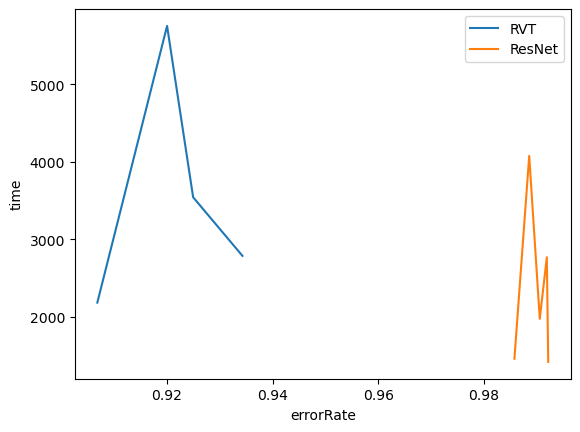

In [ ]:
sns.lineplot(data=df[df.backbone == 'rvt'], x='errorRate', y='time', label='RVT')
sns.lineplot(data=df[df.backbone == 'resnet'], x='errorRate', y='time', label='ResNet')

Displaying where the cropping regions coordinates had been converged according to a given `generation`.


Some notes:
apparently the mean initialisation seems not to influence the final convergence given sufficient instances to explore the space for a reasonable amount of generations. Some parameters are still needed to be tuned. The entropy minimum reached by the search algorithm is not corresponding to the perfectly cropped image subject. We may hope to rely on few optimisation evolutionary runs in order to get some original test image cropped areas to be used as prediction.
We can also try to classify each test image according to the resulting candidates over $N$ generations
